In [1]:
# /data/wut/enformer


import tensorflow.compat.v2 as tf
# pip install tensorflow-hub
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import kagglehub
from difflib import ndiff
from Bio import pairwise2
from Bio.Seq import Seq
import edlib
from utils import *

2025-09-08 16:08:09.062799: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 16:08:09.077283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757318889.093747 3380045 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757318889.098029 3380045 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757318889.110580 3380045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
# model_path = 'https://hub.tensorflow.google.cn/deepmind/enformer/1'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = "/data/wut/data/ref/GRCh38/HZAU_cohort_wdy/NCBI.GRCh38.no_alt.no_ctgs.fasta"
# clinvar_vcf = '/root/data/clinvar.vcf.gz'
SEQUENCE_LENGTH = 393216

model = Enformer("/data/wut/models/enformer")
fasta_extractor = FastaStringExtractor(fasta_file)

targets_txt = "/data/wut/models/enformer/targets_human.txt"
# 5314 targets_human.txt
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.head(3)


I0000 00:00:1757318895.718695 3380045 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22321 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1757318895.740747 3380045 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21975 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:07:00.0, compute capability: 8.6


,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion


In [3]:
# @title Compute contribution scores

# # HN_DEL_03416（chr1: 108,190,703 – 108,193,180）
# chr1:108190703-108193180

# interval
target_interval = kipoiseq.Interval('chr1', 108190703, 108193180)  # @param
sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

I0000 00:00:1757318902.619877 3380212 cuda_dnn.cc:529] Loaded cuDNN version 90501


In [4]:
# enformer gradient&input

target_mask = np.zeros_like(predictions)
# print(target_mask)
target_mask.shape

# for idx in [447, 448, 449]:  # 后续计算梯度时，只关注这些位置的预测输出
#   target_mask[idx, 4828] = 1
#   target_mask[idx, 5111] = 1
# # 用来指定 我们关注哪些输出 track 的哪些位置，即梯度贡献的目标

for idx in range(896):  # 后续计算梯度时，只关注这些位置的预测输出
  target_mask[idx, 4675] = 1

# print(target_mask)
target_mask.shape

# 计算 输入序列每个碱基对目标输出的梯度贡献
contribution_scores = model.contribution_input_grad(sequence_one_hot.astype(np.float32), target_mask).numpy()
# print(contribution_scores)
contribution_scores.shape

pooled_contribution_scores = tf.nn.avg_pool1d(np.abs(contribution_scores)[np.newaxis, :, np.newaxis], 128, 128, 'VALID')[0, :, 0].numpy()[1088:-1088]
# print(pooled_contribution_scores)
pooled_contribution_scores.shape

enformer_gradient_x_input = np.minimum(pooled_contribution_scores, 0.03)
# 将贡献值限制在 最大 0.03。
# 目的：
# 防止极端梯度值主导可视化。
# 便于绘图或者后续归一化。

np.abs(contribution_scores)：取绝对值，忽略正负，关注贡献大小。

[np.newaxis, :, np.newaxis]：

增加 batch 和 channel 维度，变成 [1, seq_len, 1]，适合 1D 池化。

tf.nn.avg_pool1d(..., 128, 128, 'VALID')：

1D 平均池化，窗口大小 128，步长 128。

目的是把 Enformer 对每个 128 bp bin 的预测贡献聚合。

[0, :, 0].numpy()：

去掉 batch 和 channel 维度。

[1088:-1088]：

截取中间部分，去掉模型输入的两端 padding 区域。

典型做法：Enformer 输入长度较大，中间才对应核心序列。

In [5]:
# 修改plot_tracks函数

In [6]:
# tracks = {'CAGE predictions': predictions[:, 4828],
#           'Enformer gradient*input': np.minimum(pooled_contribution_scores, 0.03)}
# plot_tracks(tracks, target_interval.resize(SEQUENCE_LENGTH));  # 考虑上下文，但是只绘制target_interval

# # 实际无效
# # 它预测 896 个 128bp 的 bin，对应于输入序列的核心 114688 bp。

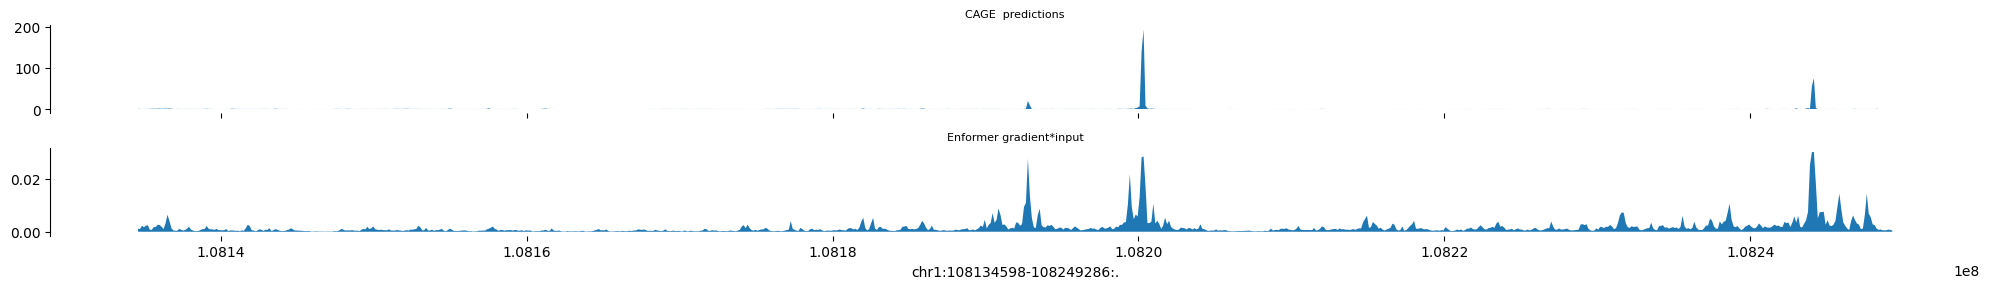

In [7]:
tracks = {'CAGE  predictions': predictions[:, 4675],
          'Enformer gradient*input': np.minimum(pooled_contribution_scores, 0.03)}
plot_tracks(tracks, target_interval.resize(896*128))  # 全部 不仅仅target

Enformer gradient*input 检测出来第二个启动子区域，但是CAGE没有

In [8]:
target_interval

Interval(chrom='chr1', start=108190703, end=108193180, name='', strand='.', ...)

In [9]:
deletion = fasta_extractor.extract(target_interval)
deletion

'TTTTAATCAGTTGAGTTTTGTCTATATAAACAAATTTTCCTACTGGGGAGGTGGAGACGTGTGGGAAGAGACCTCACATCAAAACCTCCTAACGATGTGACTGCCACTTGAGGAAAAGTCACAATGGTGCTCCTCTGAAACAGAATGTTCTGTGTGGTTGGTGCAGAATTCTCTGGGGACACCCCTCCCTTGGGTTTTGACATGTGAACCCTCCTCAGTCACCACTAGGTACACAAAGCGTCCTTGCCAAAAATGCAAGACAGCTCTACAAACCTTTTGTTTCAATAAGGAAGAAATGTGTTTCAAAAGATTCGACTTGATAGCTAACCCAGAATTTCTTATGAAAGGCTAGTTTGTATCAAATAAACAAATACAACTTACACTTGCAAATCTAAATATAAGAGTGTCTTTAAACAAATATGAAGAACACTTAACTTTTTTTTTTTCTTTTTGAGATGGAGTCTCACTCTGTCACCCAGGTTGGAGTGCAGTGATGCAATCTCAGCTTGCTGCAACCTCTGCCTCCCAGGCTCAAGTGATTCTCCTGCCTCAGCCTCCTGGGACTACACACACCCACCACCACACCCGGTTAATTTTTGCATTTTTAGTAGAGATGGGGTTTTACCATATTGGCCAGGCTGGTCTTGAACTCCTGACCCCAAGTGATCCACCTGCCTTGGCCTCCCAAAGTGCTGGAATTACAGGCATGAGCCACTGCACCTGAACAAGAACACTTAACTTTAAAAGGAGAAACACTGCTTTTTTCTAGGAATTAAAAATCCAGATAAGCTTTGCAGAAATAACATTTTGGACTGAATTGGTCCACAGAAAGTACACAGTCCAGGCCTCTGATATAACAGATGAGGATACCAGGGTATGGGGCTTGGAATATAGAATGTGCTCAAACTAGAACTGACCCATGACTGAATGGATGCTTCAATATTCCCAAAGTTCACATGGCTAATAGAAAGAGTTTTACTAAATTTCAACATGACAGAA

In [10]:
len(fasta_extractor.extract(target_interval))

2477

In [11]:
def build_tracks(sv_id,df_targets, reference_prediction, alternate_prediction, variant_track, snp_path,seq_extractor,interval,center,keyword=None, start=0, end=50):
    tracks = {"variant": variant_track}
    # 筛选符合条件的行
    if keyword:
        df_filtered = df_targets[df_targets["description"].str.contains(keyword, case=False, na=False)]
    else:
        df_filtered = df_targets
    end = min(end, len(df_filtered))
    df_filtered = df_filtered.iloc[start:end]

    df = pd.read_csv(snp_path, sep="\t", header=None,
                 names=["chrom", "start", "end", "rsid", "ref", "alt"])

    for t, row in df_filtered.iterrows():
        desc = row["description"]

        target_mask = np.zeros_like(predictions)
        for idx in range(896):  # 后续计算梯度时，只关注这些位置的预测输出
            target_mask[idx, t] = 1
        contribution_scores = model.contribution_input_grad(sequence_one_hot.astype(np.float32), target_mask).numpy()
        pooled_contribution_scores = tf.nn.avg_pool1d(np.abs(contribution_scores)[np.newaxis, :, np.newaxis], 128, 128, 'VALID')[0, :, 0].numpy()[1088:-1088]
        enformer_gradient_x_input = np.minimum(pooled_contribution_scores, 0.03)
        tracks[f"{desc} Enformer gradient*input"] = enformer_gradient_x_input
        
        tracks[f"{desc} ref"] = reference_prediction[:, t]
        tracks[f"{desc} {sv_id} alt"] = alternate_prediction[:, t]

        for i,row in df.iterrows():
            snp_chrom = row['chrom']
            snp_start = row['start']
            snp_end = row['end']
            snp_rsid = row['rsid']
            snp_ref = row['ref']
            snp_alt = row['alt']
            variant = kipoiseq.Variant(snp_chrom, snp_end, snp_ref, snp_alt, id=snp_rsid)
            alternate = seq_extractor.extract(interval, [variant],anchor=center)
            alternate_prediction = model.predict_on_batch(one_hot_encode(alternate)[np.newaxis])['human'][0]
            tracks[f"{desc} {snp_rsid} alt"] = alternate_prediction[:, t]

    return tracks

In [16]:
# 包装处理DEL函数

def analyze_del_sv(
    sv_id: str,
    chrom: str,
    start: int,
    end: int,
    snp_path: str,
    model=Enformer("/data/wut/models/enformer"),
    fasta_extractor=FastaStringExtractor("/data/wut/data/ref/GRCh38/HZAU_cohort_wdy/NCBI.GRCh38.no_alt.no_ctgs.fasta"),
    df_targets=pd.read_csv("/data/wut/models/enformer/targets_human.txt", sep="\t"),
    sequence_length: int = 393216,
    bin_size: int = 128,
    keyword: str = "Reference",
    target_start: int = 0,
    target_end: int = 10,
    output_dir: str = "./"
):
    """
    处理DEL类型SV并生成可视化PDF.

    Args:
        sv_id (str): SV的ID
        chrom (str): 染色体名，例如 "chr1"
        start (int): deletion起始位置
        end (int): deletion终止位置
    """
    # 构建variant
    ref_seq = fasta_extractor.extract(kipoiseq.Interval(chrom, start, end))
    alt_seq = "N" * len(ref_seq)  # DEL替换为N
    variant = kipoiseq.Variant(chrom, start, ref_seq, alt_seq, id=sv_id)

    # 构造输入interval
    interval = kipoiseq.Interval(variant.chrom, variant.start, variant.start).resize(sequence_length)
    seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)
    center = interval.center() - interval.start

    # 提取参考与突变序列
    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    # Enformer预测
    reference_prediction = model.predict_on_batch(one_hot_encode(reference)[np.newaxis])['human'][0]
    alternate_prediction = model.predict_on_batch(one_hot_encode(alternate)[np.newaxis])['human'][0]

    nbins = reference_prediction.shape[0]
    genomic_interval = interval.resize(nbins * bin_size)

    # 计算DEL对应bin范围
    del_start_bin = max(0, (start - genomic_interval.start) // bin_size)
    del_end_bin = min(nbins, (end - genomic_interval.start) // bin_size)

    variant_track = np.zeros(nbins, dtype=bool)
    variant_track[del_start_bin:del_end_bin + 1] = True

    # 构造tracks
    tracks = build_tracks(
        sv_id,
        df_targets,
        reference_prediction,
        alternate_prediction,
        variant_track,
        keyword=keyword,
        start=target_start,
        end=target_end,
        snp_path=snp_path,
        seq_extractor=seq_extractor,
        interval=interval,
        center=center
    )

    # 输出pdf文件
    output_file = f"{output_dir}/{sv_id}.pdf"
    plot_tracks(tracks, interval.resize(nbins * bin_size // 5), height=0.8, width=8,output_file=output_file)

    print(f"[+] SV {sv_id} 分析完成，结果已保存到 {output_file}")
    return output_file

In [17]:
analyze_del_sv("HN_DEL_03416", "chr1", 108190703, 108193180,snp_path="SLC25A24.snps.bed")

[+] SV HN_DEL_03416 分析完成，结果已保存到 .//HN_DEL_03416.pdf


'.//HN_DEL_03416.pdf'